In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import r2_score as r2_score 

from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.linear_model import Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import KFold

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read wheat and weather data

In [15]:
wheat = pd.read_csv("data/crop/national_yield_with_trend.csv")
weather = pd.read_csv("data/features/era_features.csv")

x_y_cv = weather.merge(wheat[["year", "yield [kg/ha]"]], on="year")
x_y_cv = x_y_cv.loc[x_y_cv["year"] < 2017].reset_index(drop=True) # Leave test set aside
x_y_cv = x_y_cv.loc[:, [c for c in x_y_cv.columns if ("_8" not in c)]]

### 2. Detrend national wheat yield
.. using all previous years to estimate the slope (data since 69 is available)

#### 2.1 Estimate slope and bias for each year's trend correction

In [16]:
# dictionary that stores for each year the slope and bias estimated from the previous years
years_to_params = {}
for year in x_y_cv["year"].unique().tolist():
    years_to_params[year] = {"slope":np.nan, "bias":np.nan}
    # from the wheat dataset get the 23 preceding years to the current year, e.g. for year 1993, get 1969-1992
    year_range = wheat.loc[wheat["year"].isin(list(range(year-23, year))), ["year", "yield [kg/ha]"]]
    # estimate slope and bias of a linear fit through these preceding years and store them in dictionary
    slope, bias= np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1)
    years_to_params[year]["slope"] = slope
    years_to_params[year]["bias"] = bias
years_to_params[2010]

{'slope': 40.186997705965986, 'bias': -77958.053590407}

#### 2.2 Yield trend analysis and decomposition

379.99


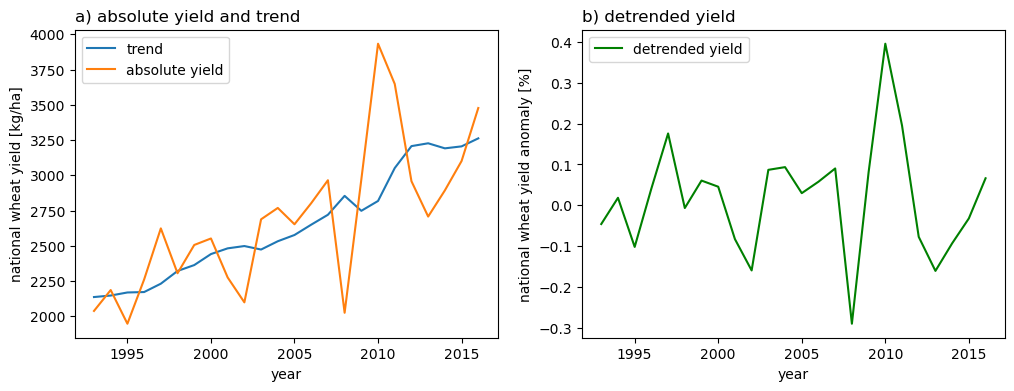

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
trend_estimated = []

for year in x_y_cv["year"].unique().tolist():
    value = year * years_to_params[year]["slope"] + years_to_params[year]["bias"]
    trend_estimated.append(value)

ax1.plot(x_y_cv["year"].unique().tolist(), trend_estimated, label="trend")
ax1.plot(x_y_cv["year"].unique().tolist(), x_y_cv["yield [kg/ha]"], label="absolute yield")
ax1.set_title("a) absolute yield and trend", loc="left")
ax1.set_ylabel("national wheat yield [kg/ha]")
ax1.set_xlabel("year")
ax1.legend()

# print RMSE of trend estimation
print(np.round(mse(trend_estimated, x_y_cv["yield [kg/ha]"].values.tolist(), squared=False), 2))

x_y_cv["yield_trend [kg/ha]"] = trend_estimated
x_y_cv["yield anomaly [%]"] = (x_y_cv["yield [kg/ha]"] - x_y_cv["yield_trend [kg/ha]"])/x_y_cv["yield_trend [kg/ha]"]

ax2.plot(x_y_cv["year"], x_y_cv["yield anomaly [%]"], color="green", label="detrended yield");
ax2.set_title("b) detrended yield", loc="left");
ax2.set_ylabel("national wheat yield anomaly [%]");
ax2.set_xlabel("year");
ax2.legend();


### 3. Basis expansion

Here, we expand to three cases: tmean_squared, rain_squared, and tmean_times_rain.

Before we expand the features for a year y, we standardize the corresponding values using the z-score with mean and std learned from all other years except y.

In [18]:
def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with tmean_squared, rain_squared, and tmean_times_rain features
    """
    # split data
    X = data.loc[:, [c for c in data.columns if ("rain" in c) or ("tmean" in c)]].reset_index(drop=True)
    y = data.loc[:, [c for c in data.columns if ("rain" not in c) and ("tmean" not in c)]].reset_index(drop=True)
    X_columns = X.columns
    
    # standardize features LOYO
    num_folds = X.shape[0]
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    scaled_features = [0] * num_folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[list(train_index)], X.iloc[test_index]
        scaler = StandardScaler()
        # Standardize the data for this fold 
        X_test_standardized = scaler.fit(X_train).transform(X_test)
        scaled_features[test_index[0]] = X_test_standardized.flatten()
    X = pd.DataFrame(scaled_features, columns=X_columns)
    
    # store features and target in variables for better readability
    X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
    X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]
    
    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain * X_temp.values
    X_tmean_squared.columns = ["tmean_squared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rain_squared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmean_rain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True))
    data_expanded = pd.concat([y, X], axis=1)
    
    return data_expanded

In [19]:
x_y_cv_expanded = apply_basis_expansion(x_y_cv)

### 3. Identify relevant locations for weather features

- there are more than 100 municipalities with tmean and rainfall data
- we perform LOYO-CV to select the municipalities that best explain national wheat yield

In [109]:
def forecast_of_areas(data, r2_threshold):
    """
    fits a national yield model for each area and returns best performances as dictionary
    params: 
        data: dataframe, with features from all municipalities
        r2_threshold: float, definition of a well-performing area
    returns:
        area_to_r2: dictionary, with keys being the municipalities and values the best model that could be fit
    """
    area_to_r2 = {}
    municipalities = list(set([c.split("_")[2] if c not in ['year', 'yield [kg/ha]', 'yield_trend [kg/ha]', 'yield anomaly [%]'] else 'santa fe san cristobal' for c in data.columns]))
    for area in municipalities:
        best_r2 = r2_threshold
        for no_of_features in list(range(1,5)):
            # split
            X = data.loc[:, [c for c in [l for l in data.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[2] == area]]
            y = data["yield anomaly [%]"]
            X_columns = X.columns
            
            # remove correlated features
            cor_matrix = X.corr().abs().round(2)
            upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
            to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.6)]
            X = X.drop(to_drop, axis=1)

            # pipeline object for regression model
            pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), ('selector', SelectKBest(f_regression, k=no_of_features)), ('estimator', Ridge())])
            
            # Perform LOOCV and obtain predictions
            loo = LeaveOneOut()
            y_pred = cross_val_predict(pipeline, X, y, cv=loo)

            # Calculate metrics
            rmse = np.round(100*mse(y_pred, y, squared=False), 1)
            meanabserr = np.round(100*mae(y_pred, y), 1)
            r = np.round(pearsonr(y_pred, y)[0], 2)
            current_r2 = np.round(r2_score(y, y_pred), 2)

            if current_r2 > best_r2:
                best_r2 = current_r2
                area_to_r2[area] = current_r2

    return area_to_r2

In [208]:
areas_to_r2 = forecast_of_areas(x_y_cv_expanded, 0.15)

In [209]:
print("The best performance comes from: \n{}".format("', '".join(list(areas_to_r2.keys()))))

The best performance comes from: 
buenos aires bahia blanca', 'buenos aires hipolito yrigoyen', 'buenos aires general la madrid', 'buenos aires trenque lauquen', 'buenos aires laprida', 'entre rios colon', 'santa fe san cristobal', 'buenos aires coronel pringles', 'buenos aires coronel suarez', 'buenos aires tornquist', 'buenos aires saavedra', 'buenos aires coronel dorrego', 'santa fe san justo


### Note: I tried several combinations of subsets from the best performing municipalities and found that the following subset worked best on the national yield model:

["buenos aires bahia blanca", "buenos aires coronel pringles", "buenos aires hipolito yrigoyen", "buenos aires coronel dorrego", "buenos aires coronel suarez", "buenos aires saavedra", "santa fe san justo"]

### 4. Filter features 


In [304]:
selected_areas = ["buenos aires bahia blanca", "buenos aires coronel pringles", "buenos aires hipolito yrigoyen", "buenos aires coronel dorrego", "buenos aires coronel suarez", "buenos aires saavedra", "santa fe san justo"]
x_y_cv_filtered = x_y_cv_expanded.loc[:, ["yield anomaly [%]", "yield [kg/ha]", "year"] + [c for c in [l for l in x_y_cv_expanded.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[2] in selected_areas]]
x_y_cv_filtered.head()

,yield anomaly [%],yield [kg/ha],year,tmean_squared_buenos aires bahia blanca_9,tmean_squared_buenos aires bahia blanca_10,tmean_squared_buenos aires bahia blanca_11,tmean_squared_buenos aires coronel dorrego_9,tmean_squared_buenos aires coronel dorrego_10,tmean_squared_buenos aires coronel dorrego_11,tmean_squared_buenos aires coronel pringles_9,...,tmean_rain_buenos aires coronel suarez_11,tmean_rain_buenos aires hipolito yrigoyen_9,tmean_rain_buenos aires hipolito yrigoyen_10,tmean_rain_buenos aires hipolito yrigoyen_11,tmean_rain_buenos aires saavedra_9,tmean_rain_buenos aires saavedra_10,tmean_rain_buenos aires saavedra_11,tmean_rain_santa fe san justo_9,tmean_rain_santa fe san justo_10,tmean_rain_santa fe san justo_11
0,-0.046171,2037.439151,1993,0.012301,0.032561,2.153812,0.036666,0.026702,2.026047,0.000578,...,-1.709998,-0.633449,-0.161731,-1.595325,0.117976,-0.179063,-1.894196,1.431995,-2.176832,-1.767627
1,0.018138,2185.741998,1994,0.261828,0.887682,1.842640,0.427070,1.150989,1.518990,0.302513,...,-1.356695,-0.221416,0.594248,-0.691174,-0.448280,0.501521,-1.245701,0.674637,-1.051838,0.308643
2,-0.102265,1946.759707,1995,0.656292,0.149748,0.017397,0.232077,0.193840,0.000430,0.820902,...,0.446025,-0.897565,0.192081,0.235230,-1.715249,0.122830,0.227664,-0.078851,0.135663,-0.257157
3,0.040968,2260.470320,1996,0.002588,0.433028,0.513886,0.014960,0.247666,0.272959,0.002957,...,0.483659,-0.099919,-0.209704,-0.078975,0.124906,0.082525,0.500526,-0.482130,-0.040851,0.248492
4,0.175913,2623.252920,1997,2.051033,0.602919,1.072271,3.824907,0.587907,1.570172,2.305707,...,1.151788,0.595909,-1.323840,-0.711850,-0.022764,-0.352542,1.328328,-2.655284,0.014751,-0.006841


### 5. Train national model

In [305]:
def train_and_validate_national_model(data, corr_threshold, no_features):
    """
    apply LOYO-CV on data.
    params:
        data: dataframe, contains features and targets
        corr_threshold: float, to filter correlated features before model fit
        no_features: int, number of features to train the model on
    return (as tuple):
        features: dictionary, all features that have been selected for all folds
        rmse, current_r2, pearson_r: float, performance metrics
        y_pred, y: list, predictions and ground truth
    """
    features = {}
    # feature-target split
    X = data.loc[:, [c for c in data.columns if ("rain" in c) or ("tmean" in c)]]
    y = data["yield anomaly [%]"]
    X_columns = X.columns

    # remove correlated features
    cor_matrix = X.corr().abs().round(2)
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)]
    X = X.drop(to_drop, axis=1)
        
    # pipeline object for regression model
    pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), ('selector', SelectKBest(f_regression, k=no_features)), ('estimator', Ridge())])

    # Perform LOOCV and obtain predictions
    loo = LeaveOneOut()
    y_pred = cross_val_predict(pipeline, X, y, cv=loo)

    output = cross_validate(pipeline, X, y, scoring="neg_mean_squared_error", cv=loo, return_estimator=True)
    for idx,estimator in enumerate(output['estimator']):
        selected_features = estimator.named_steps["selector"].get_feature_names_out(X.columns).tolist()
        features[idx] = selected_features
    #features = [c.tolist() for c in features]   
    #features = list(set([item for sublist in [c.tolist() for c in features] for item in sublist]))
    rmse = np.round(mse(y, y_pred, squared=False), 4)
    current_r2 = np.round(r2_score(y, y_pred), 4)
    pearson_r = np.round(pearsonr(y, y_pred)[0], 2)

    return (features, rmse, current_r2, pearson_r, y_pred, y)

In [306]:
# rmse is 0.0737, r2 is 0.7024 for corr_threshold 0.7 and 5 features
best_rmse = 0.9
feature_list = []
for c in [0.7]:
    for f in [5]:
        features, rmse, current_r2, _, y_pred, y = train_and_validate_national_model(x_y_cv_filtered, c, f)
        print("rmse is {}, r2 is {} for corr_threshold {} and {} features".format(rmse, current_r2, c, f))
        if rmse < best_rmse: 
            best_rmse = rmse
            feature_list = features
print(feature_list)

rmse is 0.0737, r2 is 0.7024 for corr_threshold 0.7 and 5 features
{0: ['tmean_squared_buenos aires bahia blanca_11', 'rain_squared_buenos aires hipolito yrigoyen_9', 'rain_squared_santa fe san justo_11', 'tmean_rain_buenos aires bahia blanca_11', 'tmean_rain_santa fe san justo_11'], 1: ['tmean_squared_buenos aires bahia blanca_11', 'rain_squared_buenos aires hipolito yrigoyen_9', 'rain_squared_santa fe san justo_11', 'tmean_rain_buenos aires bahia blanca_11', 'tmean_rain_santa fe san justo_11'], 2: ['tmean_squared_buenos aires bahia blanca_11', 'rain_squared_buenos aires hipolito yrigoyen_9', 'rain_squared_santa fe san justo_11', 'tmean_rain_buenos aires bahia blanca_11', 'tmean_rain_santa fe san justo_11'], 3: ['tmean_squared_buenos aires bahia blanca_11', 'rain_squared_buenos aires hipolito yrigoyen_9', 'rain_squared_santa fe san justo_11', 'tmean_rain_buenos aires bahia blanca_11', 'tmean_rain_santa fe san justo_11'], 4: ['tmean_squared_buenos aires bahia blanca_11', 'rain_squared_

#### analyse multicollinearity

In [307]:
def calculate_variance_inflation_factor(data):
    """
    calculate variance inflation factor.
    params:
        data: dataframe, containing all features
    returns:
        vif_series: series, wit the VIF for each variable
    """
    VIF = add_constant(data)
    result = pd.Series([variance_inflation_factor(VIF.values, i) 
                for i in range(VIF.shape[1])], 
                index=VIF.columns)
    return result

Check if all folds had valid solutions, where the selected features have multicollinearity of less than 3:

In [308]:
max_vif = 0
for fold in feature_list:
    result = calculate_variance_inflation_factor(x_y_cv_filtered[feature_list[fold]])
    vif_result = np.round(result.loc[~result.index.str.contains("const")].max(), 2)
    if vif_result > max_vif:
        print(vif_result)
        max_vif = vif_result

2.92


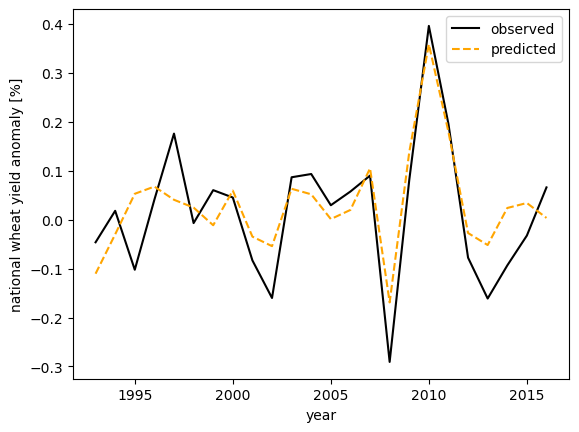

In [309]:
(features, rmse, current_r2, pearson_r, y_pred, y) = train_and_validate_national_model(x_y_cv_filtered, 0.7, 5)

plt.plot(x_y_cv_filtered["year"], y, color="black", label="observed");
plt.plot(x_y_cv_filtered["year"], y_pred, linestyle="dashed", color="orange", label="predicted");
plt.ylabel("national wheat yield anomaly [%]")
plt.xlabel("year")
plt.legend();

The hindcast data needs bias-adjustment for the chosen locations, hence we store a filtered ERA5 for later use:

In [11]:
era_preprocessed = pd.read_csv("data/ERA5/era5_preprocessed.csv")
era_preprocessed = era_preprocessed.loc[era_preprocessed["name"].isin(["buenos aires bahia blanca", "buenos aires coronel pringles", "buenos aires hipolito yrigoyen", "buenos aires coronel dorrego", "buenos aires coronel suarez", "buenos aires saavedra", "santa fe san justo"])].reset_index(drop=True)

era_preprocessed.to_csv("nmme/data/era_filtered_locations_v2.csv", index=False)
era_preprocessed.to_csv("c3s/data/era_filtered_locations_v2.csv", index=False)
era_preprocessed.to_csv("clik-apcc/data/era_filtered_locations_v2.csv", index=False)

### 6. Express as absolute yield forecast

.. by applying the inverse of the yield correction to the yield anomaly estimations

7.57


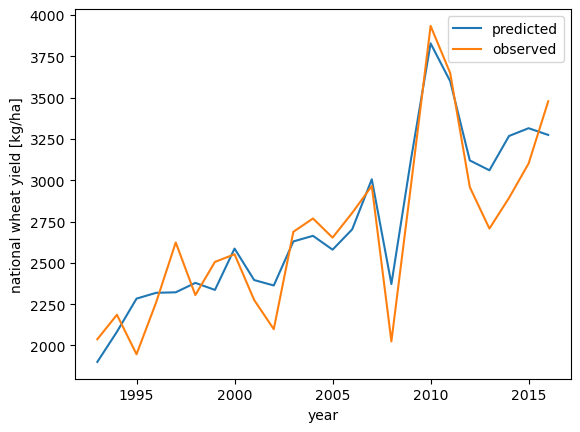

In [310]:
z = x_y_cv_filtered["year"].apply(lambda x: years_to_params[x]["slope"] * x + years_to_params[x]["bias"])

plt.plot(x_y_cv_filtered["year"], y_pred * z + z, label="predicted");
plt.plot(x_y_cv_filtered["year"], x_y_cv_filtered["yield [kg/ha]"], label="observed");
plt.ylabel("national wheat yield [kg/ha]")
plt.xlabel("year")
plt.legend();

print(np.round(100 * np.mean(mse(y_pred * z + z, x_y_cv_filtered["yield [kg/ha]"], squared=False)/x_y_cv_filtered["yield [kg/ha]"]), 2))

### Filter by selected features

In [311]:
relevant_features = list(set([item for sublist in list(feature_list.values()) for item in sublist]))

In [312]:
x_y_cv_filtered = x_y_cv_filtered.assign(model="ERA", init_month=12).set_index(["model", "year", "init_month", "yield [kg/ha]", "yield anomaly [%]"])[relevant_features].reset_index(drop=False)

In [313]:
x_y_cv_filtered.head()

,model,year,init_month,yield [kg/ha],yield anomaly [%],tmean_rain_santa fe san justo_11,rain_squared_buenos aires hipolito yrigoyen_9,tmean_rain_santa fe san justo_10,tmean_squared_buenos aires bahia blanca_11,tmean_rain_buenos aires bahia blanca_9,rain_squared_santa fe san justo_11,tmean_rain_buenos aires bahia blanca_11,tmean_rain_buenos aires hipolito yrigoyen_11
0,ERA,1993,12,2037.439151,-0.046171,-1.767627,0.256655,-2.176832,2.153812,-0.101273,1.226205,-1.297937,-1.595325
1,ERA,1994,12,2185.741998,0.018138,0.308643,0.235756,-1.051838,1.842640,-0.422610,0.235401,-1.490589,-0.691174
2,ERA,1995,12,1946.759707,-0.102265,-0.257157,0.793068,0.135663,0.017397,-1.151954,0.055487,0.020478,0.235230
3,ERA,1996,12,2260.470320,0.040968,0.248492,0.725714,-0.040851,0.513886,-0.049864,0.228297,0.678951,-0.078975
4,ERA,1997,12,2623.252920,0.175913,-0.006841,0.374834,0.014751,1.072271,0.027622,0.029486,0.921794,-0.711850


### 7. Export datasets

In [314]:
x_y_cv_filtered.to_csv("data/features/era_features_and_target_v3.csv", index=False)